In [2]:
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = list(stopwords.words('english'))
new_stop=['(',',','.','..','"',')','>','’','<','“','/','?']
stop.extend(new_stop)

porter = PorterStemmer()

URL_DATA = 'Dataset.xlsx'


def remove_punctuation(description):
    """Function to remove punctuation"""
    table = str.maketrans('', '', string.punctuation)
    return description.translate(table)


def remove_stopwords(text):
    """Function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)


def stemmer(stem_text):
    """Function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)


def read_data(path):
    """Function to read and clean text data"""
    data = pd.read_excel(path, header=0, index_col=0)
    data = data[['Judgment','Judgment Status']].copy()
    data['Judgment'] = data['Judgment'].astype(str)
    data['Judgment'] = data['Judgment'].apply(remove_punctuation)
    data['Judgment'] = data['Judgment'].apply(remove_stopwords)
    data['Judgment'] = data['Judgment'].apply(stemmer)
    return data


if __name__ == '__main__':
    dataset = read_data(URL_DATA)
    print(dataset.shape)
    print(dataset)
    dataset.to_csv('New Data.csv',encoding='utf-8')

(320, 2)
                                              Judgment  Judgment Status
Id                                                                     
1    appeal judgment decre bombay high court stone ...                1
2    applic articl 32 1 constitut enforc applic fun...                2
3    appeal judgment high court hyderabad articl 37...                0
4    appeal articl 3744 constitut judgment decre hi...                0
5    petit art 136 constitut pray special leav appe...                3
..                                                 ...              ...
316  1 revision applic instanc defend state orissa ...                1
317  1 writ petit taken question valid decis nagaon...                3
318  saptangshu basu senior advoc mr partha basu mr...                3
319  mr arunava ghosh mr supriya ranjan saha advoc ...                3
320  introduct whether seat parliament legislatur s...                1

[320 rows x 2 columns]


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalMaxPool1D, Conv1D
from tensorflow.keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers.convolutional import MaxPooling1D
from keras import utils

In [10]:
df = pd.read_csv('New Data.csv', header=0,index_col=0)
df.head()

,Judgment,Judgment Status
Id,,
1,appeal judgment decre bombay high court stone ...,1
2,applic articl 32 1 constitut enforc applic fun...,2
3,appeal judgment high court hyderabad articl 37...,0
4,appeal articl 3744 constitut judgment decre hi...,0
5,petit art 136 constitut pray special leav appe...,3


In [11]:
sentences = df['Judgment']
y = df['Judgment Status']

from sklearn.model_selection import train_test_split

sentences_train, sentences_test, train_y, test_y = train_test_split(sentences, y, test_size=0.25, random_state=42)

In [12]:
tokenize = Tokenizer(num_words=10000)
tokenize.fit_on_texts(sentences_train)

train_X = tokenize.texts_to_sequences(sentences_train)
test_X = tokenize.texts_to_sequences(sentences_test)

vocab_size = len(tokenize.word_index) + 1  

print(sentences_train[2])
print(train_X[0])

applic articl 32 1 constitut enforc applic funda mental right carri busi guarante articl 19 1 constitut fact case appear judgment nuruddin petition radhel agarwala opposit parti mc setalvad attorneygener india sikri union india pearyl banerji advocategener shri ram state uttar pradesh 1950 may 19 judgment court deliv da ji read judgment court applic articl 32 constitu tion india made rashid ahm enforc fundament right carri busi said complet stop respond munici pal board kairana fact shortli follow petition aratia commiss agent carri wholesal busi veget fruit kairana district muzaffarnagar 568 state uttar pradesh carri busi ness last two year rent shop bazar jama masjid town kairana recent byelaw respond board regul sale veget fruit within limit municip march 1949 respond board publish certain propos bye law made section 298 munic ipal act 1916 byelaw pass respond board 19th april 1949 confirma tion commission byelaw came oper 1st januari 1950 anticip new byelaw come effect respond boar

In [13]:
X_train = pad_sequences(train_X, padding='post', maxlen=1000)  
X_test = pad_sequences(test_X, padding='post', maxlen=1000)

In [52]:
embedding_dim = 8
maxlen=1000
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(embedding_dim, 3, padding='same',activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(4, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 1000, 8)           137776    
                                                                 
 conv1d_16 (Conv1D)          (None, 1000, 8)           200       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 500, 8)           0         
 g1D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 4000)              0         
                                                                 
 dense_34 (Dense)            (None, 250)               1000250   
                                                                 
 dense_35 (Dense)            (None, 4)                 1004      
                                                     

In [53]:
import time
StartTime = time.time()
history = model.fit(X_train, train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, test_y))
EndTime = time.time()
print(f"Time taken for Training and Classification: {EndTime - StartTime}s")

Epoch 1/100
8/8 [==============================] - 1s 41ms/step - loss: 1.3158 - accuracy: 0.3708 - val_loss: 1.3084 - val_accuracy: 0.3750
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 1.1842 - accuracy: 0.4750 - val_loss: 1.3115 - val_accuracy: 0.3750
Epoch 3/100
8/8 [==============================] - 0s 22ms/step - loss: 1.0514 - accuracy: 0.5875 - val_loss: 1.3213 - val_accuracy: 0.3625
Epoch 4/100
8/8 [==============================] - 0s 23ms/step - loss: 0.8912 - accuracy: 0.5958 - val_loss: 1.3092 - val_accuracy: 0.3625
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 0.6634 - accuracy: 0.9208 - val_loss: 1.3887 - val_accuracy: 0.3750
Epoch 6/100
8/8 [==============================] - 0s 22ms/step - loss: 0.4722 - accuracy: 0.8792 - val_loss: 1.3808 - val_accuracy: 0.4000
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.2805 - accuracy: 0.9833 - val_loss: 1.3773 - val_accuracy: 0.3375
Epoch 8/100
8/8 [===

In [54]:
loss, accuracy = model.evaluate(X_train, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, test_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.4750


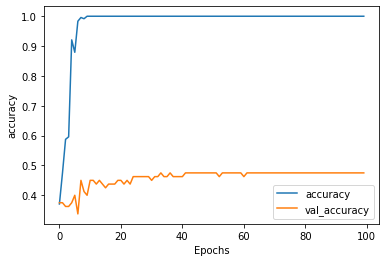

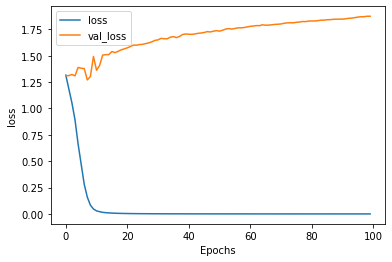

In [55]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [70]:
embedding_dim = 8
maxlen=1000
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model_2.add(Conv1D(embedding_dim, 5, padding='same',activation='relu'))
model_2.add(MaxPooling1D())
model_2.add(Flatten())
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(4, activation='sigmoid'))

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 1000, 8)           137776    
                                                                 
 conv1d_20 (Conv1D)          (None, 1000, 8)           328       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 500, 8)           0         
 g1D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 4000)              0         
                                                                 
 dense_42 (Dense)            (None, 64)                256064    
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                     

In [71]:
import time
StartTime = time.time()
history = model_2.fit(X_train, train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, test_y))
EndTime = time.time()
print(f"Time taken for Training and Classification: {EndTime - StartTime}s")

Epoch 1/100
8/8 [==============================] - 1s 40ms/step - loss: 1.3420 - accuracy: 0.3792 - val_loss: 1.3334 - val_accuracy: 0.3625
Epoch 2/100
8/8 [==============================] - 0s 18ms/step - loss: 1.2755 - accuracy: 0.4000 - val_loss: 1.3042 - val_accuracy: 0.3625
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 1.2098 - accuracy: 0.4208 - val_loss: 1.3006 - val_accuracy: 0.3875
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 1.0923 - accuracy: 0.4708 - val_loss: 1.3308 - val_accuracy: 0.3750
Epoch 5/100
8/8 [==============================] - 0s 20ms/step - loss: 0.9426 - accuracy: 0.5500 - val_loss: 1.3600 - val_accuracy: 0.3500
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 0.7525 - accuracy: 0.7833 - val_loss: 1.3543 - val_accuracy: 0.3625
Epoch 7/100
8/8 [==============================] - 0s 20ms/step - loss: 0.5464 - accuracy: 0.8542 - val_loss: 1.3600 - val_accuracy: 0.3625
Epoch 8/100
8/8 [===

8/8 [==============================] - 0s 22ms/step - loss: 2.4682e-04 - accuracy: 1.0000 - val_loss: 2.3893 - val_accuracy: 0.4000
Epoch 59/100
8/8 [==============================] - 0s 18ms/step - loss: 2.3878e-04 - accuracy: 1.0000 - val_loss: 2.3825 - val_accuracy: 0.4000
Epoch 60/100
8/8 [==============================] - 0s 20ms/step - loss: 2.3004e-04 - accuracy: 1.0000 - val_loss: 2.4011 - val_accuracy: 0.4000
Epoch 61/100
8/8 [==============================] - 0s 32ms/step - loss: 2.2214e-04 - accuracy: 1.0000 - val_loss: 2.4086 - val_accuracy: 0.4000
Epoch 62/100
8/8 [==============================] - 0s 32ms/step - loss: 2.1567e-04 - accuracy: 1.0000 - val_loss: 2.4126 - val_accuracy: 0.4000
Epoch 63/100
8/8 [==============================] - 0s 33ms/step - loss: 2.0996e-04 - accuracy: 1.0000 - val_loss: 2.4026 - val_accuracy: 0.4000
Epoch 64/100
8/8 [==============================] - 0s 32ms/step - loss: 2.0133e-04 - accuracy: 1.0000 - val_loss: 2.4117 - val_accuracy: 0.400

In [72]:
loss, accuracy = model_2.evaluate(X_train, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2.evaluate(X_test, test_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.4000


In [88]:
embedding_dim = 8
maxlen=1000
model_3 = Sequential()
model_3.add(Dropout(0.4, input_shape=(1000,)))
model_3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model_3.add(Conv1D(embedding_dim, 3, padding='same',activation='relu'))
model_3.add(MaxPooling1D())
model_3.add(Flatten())
model_3.add(Dense(250, activation='relu'))
model_3.add(Dense(4, activation='sigmoid'))

model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_3.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 embedding_30 (Embedding)    (None, 1000, 8)           137776    
                                                                 
 conv1d_29 (Conv1D)          (None, 1000, 8)           200       
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 500, 8)           0         
 g1D)                                                            
                                                                 
 flatten_27 (Flatten)        (None, 4000)              0         
                                                                 
 dense_64 (Dense)            (None, 250)               1000250   
                                                     

In [89]:
import time
StartTime = time.time()
history = model_3.fit(X_train, train_y,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, test_y))
EndTime = time.time()
print(f"Time taken for Training and Classification: {EndTime - StartTime}s")

Epoch 1/100
8/8 [==============================] - 1s 42ms/step - loss: 1.3363 - accuracy: 0.3958 - val_loss: 1.3066 - val_accuracy: 0.3625
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 1.2712 - accuracy: 0.4000 - val_loss: 1.3094 - val_accuracy: 0.3625
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 1.2218 - accuracy: 0.4000 - val_loss: 1.3400 - val_accuracy: 0.3750
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 1.1648 - accuracy: 0.4125 - val_loss: 1.3487 - val_accuracy: 0.3750
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 1.0912 - accuracy: 0.4708 - val_loss: 1.3420 - val_accuracy: 0.3750
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 0.9993 - accuracy: 0.5083 - val_loss: 1.3940 - val_accuracy: 0.3750
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 0.8677 - accuracy: 0.6917 - val_loss: 1.4455 - val_accuracy: 0.3375
Epoch 8/100
8/8 [===

In [93]:
loss, accuracy = model_3.evaluate(X_train, train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, test_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.4250
Testing Accuracy:  0.4125


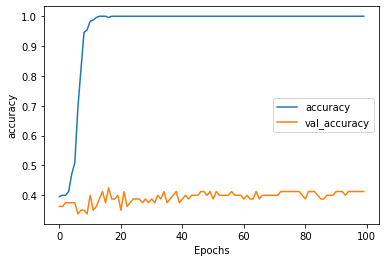

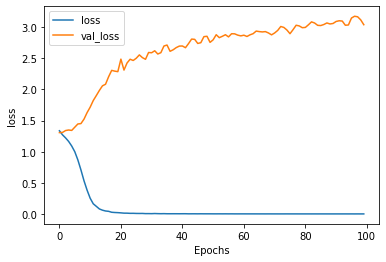

In [94]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")